In [28]:
import numpy as np
import qilisdk
import qutip as qt
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')

import hamiltonian
import dynamics
import plots
import estimator
import VQE

from qilisdk.backends import QutipBackend
from qilisdk.digital import Circuit, M, U1, CNOT, U2, U3, CZ, RX, RZ, H
from qilisdk.functionals.sampling import Sampling, SamplingResult
from qilisdk.functionals.time_evolution import TimeEvolution
from scipy.optimize import minimize

from qilisdk.analog import Schedule, X, Z, Y
from qilisdk.core import ket, tensor_prod
from qilisdk.backends import QutipBackend, CudaBackend
from qilisdk.functionals import TimeEvolution

## Create random Hamiltonian with X, Z, and ZZ terms

In [29]:
nqubits = 1
min_w = -1
max_w = 1

H_test, target_weights = hamiltonian.create_random_hamiltonian(nqubits, min_w, max_w, backend='qutip')

psi_0 = dynamics.initialize_down_state(nqubits)

print(H_test.H, "\n")

print("Weights:", target_weights)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.79319044 -0.69167846]
 [-0.69167846 -0.79319044]] 

Weights: [-0.69167846  0.79319044]


In [30]:
H_test = hamiltonian.QutipHamiltonian(nqubits)
H_test.add_x_field(0, 0.5)
H_test.add_z_field(0, 0.8)
target_weights = [0.5, 0.8]

## Perform a time evolution and extract bitstring probabilities

In [31]:
ti = 0
times = np.linspace(0.1, 2, 20)
nsteps = 1000

target_states = []
z_list = []
x_list = []

for tf in times:
    sim = dynamics.time_evolution(H_test, psi_0, ti, tf, nsteps)
    observables = dynamics.calculate_expectation_values(sim, H_test)

    z_list.append(float(observables['Sz'][-1][0])) # first index (not present here) is timestamp, second index is qubit number
    x_list.append(float(observables['Sx'][-1][0]))

    target_state = sim.states[-1]
    target_states.append(target_state)

    # simulated_probabilities = dynamics.get_bitstring_probabilities(target_state, basis='Z')

    # print("Final state:", target_state, "\n")
    # print("Bitstring probabilities:", simulated_probabilities)



## Alternative, quantum annealing evolution

In [32]:
ti = 0
times = np.linspace(0.1, 10, 30)
dt = 0.01
target_weights = [0.5, 0.8]
initial_state = tensor_prod([(ket(0) - ket(1)).unit() for _ in range(nqubits)]).unit()
Hx = sum(X(i) for i in range(nqubits)) #Driver
Ht = hamiltonian.create_hamiltonian_from_weights(nqubits, target_weights) #target
target_states = []

for T in times:

    sim = VQE.simulate_annealing(T, dt, Hx, Ht, initial_state)

    target_state_data = sim.final_state.data
    target_state_array = target_state_data.toarray()
    target_qutip_state = qt.Qobj(target_state_array, dims=[[2]*nqubits, [1]])

    target_states.append(target_qutip_state)

## Define Quantum annealing ansatz

Starting from driver Hamiltonian towards the target Hamiltonian (the one we one to learn)

In [33]:
# Define total time and timestep
dt = 0.001

# Define Hamiltonians
Hx = sum(X(i) for i in range(nqubits)) #Driver
weights_i = np.random.uniform(min_w, max_w, size=(2*nqubits + int(nqubits*(nqubits-1)/2)))
# weights_i = [0.51, 0.79]

# Prepare an equal superposition initial state
initial_state = tensor_prod([(ket(0) - ket(1)).unit() for _ in range(nqubits)]).unit()


# minimize with scipy 
res = minimize(lambda p: VQE.annealing_cost(p, times, dt, Hx, nqubits, initial_state, target_states),
               weights_i, method='COBYLA',
               options={'maxiter': 2000})


print("Optimization finished, success:", res.success, ", loss function:", res.fun)
print("best parameters:", res.x)
print(target_weights)

# [0.50238431 1.01492404]

Optimization finished, success: True , loss function: 3.1103654690154827
best parameters: [0.51631192 0.23275582]
[0.5, 0.8]


In [34]:
H_final = hamiltonian.QutipHamiltonian(nqubits)
H_final.add_x_field(0, res.x[1])
H_final.add_z_field(0, res.x[0])


final_states = []
z_list_2 = []
x_list_2 = []

for tf in times:
    sim = dynamics.time_evolution(H_final, psi_0, ti, tf, nsteps)
    observables = dynamics.calculate_expectation_values(sim, H_final)

    z_list_2.append(float(observables['Sz'][-1][0]))
    x_list_2.append(float(observables['Sx'][-1][0]))

    target_state = sim.states[-1]
    final_states.append(target_state)


In [35]:
import matplotlib.pyplot as plt
def plot_expectations(z_list, x_list, z_list_2, x_list_2):
    # Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Left plot: z lists
    ax1.plot(z_list, 'b-', label='z_list', linewidth=2)
    ax1.plot(z_list_2, 'r--', label='z_list_2', linewidth=2)
    ax1.set_title('Z Lists')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-1,1)
    # Right plot: x lists  
    ax2.plot(x_list, 'g-', label='x_list', linewidth=2)
    ax2.plot(x_list_2, 'm--', label='x_list_2', linewidth=2)
    ax2.set_title('X Lists')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

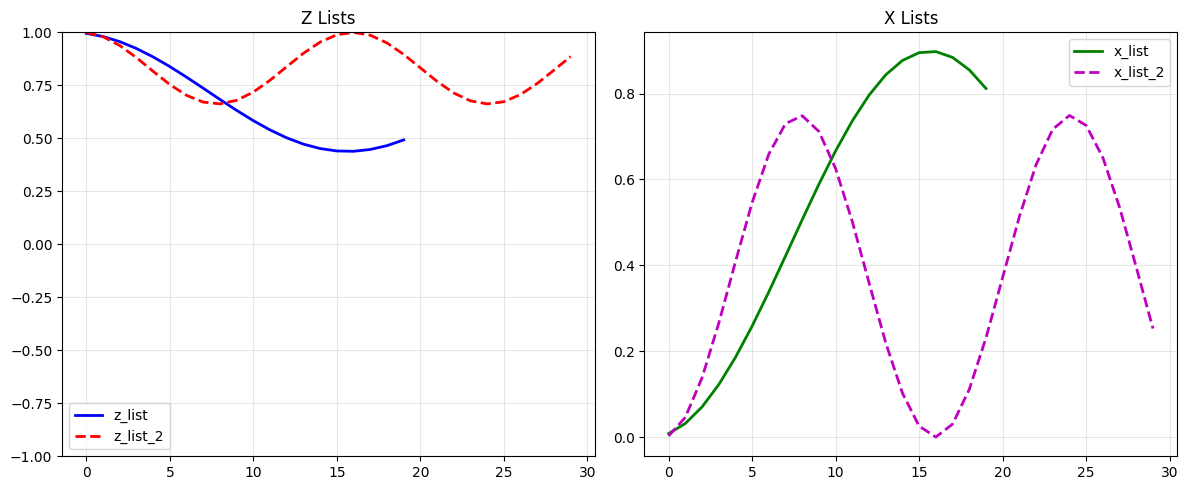

In [36]:
plot_expectations(z_list, x_list, z_list_2, x_list_2)

## Expectations calculated with annealing results

### Calculate evolution with found parameters

In [37]:
dt = 0.001
initial_state = tensor_prod([(ket(0) - ket(1)).unit() for _ in range(nqubits)]).unit()
Hx = sum(X(i) for i in range(nqubits)) #Driver
Ht = hamiltonian.create_hamiltonian_from_weights(nqubits, res.x)
final_states = []

for T in times:

    sim = VQE.simulate_annealing(T, dt, Hx, Ht, initial_state)

    target_state_data = sim.final_state.data
    target_state_array = target_state_data.toarray()
    target_qutip_state = qt.Qobj(target_state_array, dims=[[2]*nqubits, [1]])

    final_states.append(target_qutip_state)

### Compare with evolution of target parameters

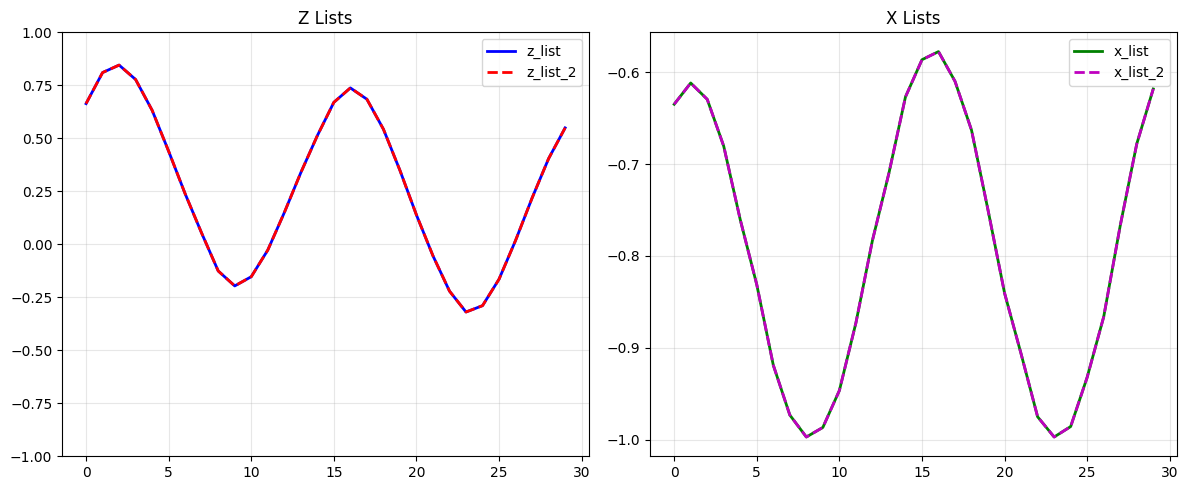

In [38]:

H_target_qutip = hamiltonian.create_hamiltonian_from_weights(nqubits, target_weights, backend='qutip')
H_final_qutip = hamiltonian.create_hamiltonian_from_weights(nqubits, target_weights, backend='qutip')



for i in range(len(final_states)):

    observables_target = dynamics.calculate_expectation_values(target_states, H_target_qutip)
    observables_final = dynamics.calculate_expectation_values(final_states, H_final_qutip)

    z_exp_1 = observables_target['Sz']
    x_exp_1 = observables_target['Sx']

    z_exp_2 = observables_final['Sz']
    x_exp_2 = observables_final['Sx']

plot_expectations(z_exp_1, x_exp_2, z_exp_1, x_exp_2)



In [39]:
print(qt.expect(qt.sigmaz(),target_states[0]))
print(qt.expect(qt.sigmaz(),final_states[0]))

0.6636843932159046
0.7504252360385342


In [40]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import minimize
# import qutip as qt
# from typing import List, Callable

# class HamiltonianLearner:
#     def __init__(self, target_state: qt.Qobj, 
#                  problem_hamiltonian_terms: List[qt.Qobj],
#                  driver_hamiltonian: qt.Qobj,
#                  initial_state: qt.Qobj,
#                  annealing_time: float = 10.0,
#                  num_time_points: int = 100):
#         """
#         Quantum annealing-based Hamiltonian learning
        
#         Parameters:
#         target_state: The target quantum state we want to prepare
#         problem_hamiltonian_terms: List of Hamiltonian terms whose coefficients we'll learn
#         driver_hamiltonian: Mixing Hamiltonian for quantum annealing
#         initial_state: Starting state for annealing protocol
#         annealing_time: Total evolution time
#         num_time_points: Number of time steps for simulation
#         """
#         self.target_state = target_state
#         self.problem_terms = problem_hamiltonian_terms
#         self.driver_hamiltonian = driver_hamiltonian
#         self.initial_state = initial_state
#         self.annealing_time = annealing_time
#         self.num_time_points = num_time_points
#         self.tlist = np.linspace(0, annealing_time, num_time_points)
        
#         # Verify dimensions match
#         self._verify_dimensions()
        
#     def _verify_dimensions(self):
#         """Verify all operators have compatible dimensions"""
#         dims = self.target_state.dims
#         for op in self.problem_terms + [self.driver_hamiltonian]:
#             if op.dims != [dims[0], dims[0]]:
#                 raise ValueError("Operator dimensions don't match state dimensions")
#         if self.initial_state.dims != dims:
#             raise ValueError("Initial state dimensions don't match target state")
    
#     def annealing_hamiltonian(self, t: float, coefficients: np.ndarray) -> qt.Qobj:
#         """
#         Time-dependent annealing Hamiltonian
#         H(t) = (1 - s(t)) * H_driver + s(t) * H_problem
#         where s(t) is the annealing schedule
#         """
#         s = t / self.annealing_time  # Linear schedule
        
#         # Problem Hamiltonian with learned coefficients
#         H_problem = sum(coeff * term for coeff, term in zip(coefficients, self.problem_terms))
        
#         # Total Hamiltonian
#         H_total = (1 - s) * self.driver_hamiltonian + s * H_problem
        
#         return H_total
    
#     def evolve_annealing(self, coefficients: np.ndarray) -> qt.Qobj:
#         """Evolve the system through annealing protocol"""
#         # Define Hamiltonian function for time evolution
#         def H_func(t, args):
#             return self.annealing_hamiltonian(t, coefficients)
        
#         # Solve Schrödinger equation
#         result = qt.sesolve(H_func, self.initial_state, self.tlist)
        
#         return result.states[-1]  # Return final state
    
#     def fidelity_loss(self, coefficients: np.ndarray) -> float:
#         """Calculate loss as 1 - fidelity between final and target states"""
#         final_state = self.evolve_annealing(coefficients)
#         fid = qt.fidelity(final_state, self.target_state)
#         return 1.0 - fid  # Loss: lower is better
    
#     def learn_coefficients(self, initial_guess: np.ndarray = None, 
#                           method: str = 'BFGS') -> dict:
#         """Optimize Hamiltonian coefficients to maximize fidelity"""
#         if initial_guess is None:
#             initial_guess = np.random.normal(0, 1, len(self.problem_terms))
        
#         # Optimization
#         result = minimize(self.fidelity_loss, initial_guess, method=method,
#                         options={'gtol': 1e-6, 'disp': True})
        
#         return {
#             'optimal_coefficients': result.x,
#             'final_fidelity': 1 - result.fun,
#             'success': result.success,
#             'message': result.message,
#             'nfev': result.nfev
#         }
    
#     def analyze_driver_effect(self, driver_strengths: List[float]):
#         """Analyze effect of driver Hamiltonian strength on learning"""
#         results = []
#         original_driver = self.driver_hamiltonian
        
#         for strength in driver_strengths:
#             self.driver_hamiltonian = strength * original_driver
#             result = self.learn_coefficients()
#             results.append({
#                 'driver_strength': strength,
#                 'final_fidelity': result['final_fidelity'],
#                 'optimal_coefficients': result['optimal_coefficients']
#             })
        
#         self.driver_hamiltonian = original_driver  # Restore original
#         return results
    
#     def analyze_initial_state_effect(self, initial_states: List[qt.Qobj]):
#         """Analyze effect of different initial states on learning"""
#         results = []
#         original_initial = self.initial_state
        
#         for state in initial_states:
#             self.initial_state = state
#             result = self.learn_coefficients()
#             results.append({
#                 'initial_state': state,
#                 'final_fidelity': result['final_fidelity'],
#                 'optimal_coefficients': result['optimal_coefficients']
#             })
        
#         self.initial_state = original_initial  # Restore original
#         return results

# # =============================================================================
# # EXAMPLE USAGE: Learning a 2-qubit Hamiltonian
# # =============================================================================

# def create_example_system():
#     """Create an example 2-qubit system for demonstration"""
    
#     # Pauli operators for 2-qubit system
#     X1 = qt.tensor(qt.sigmax(), qt.qeye(2))
#     X2 = qt.tensor(qt.qeye(2), qt.sigmax())
#     Z1 = qt.tensor(qt.sigmaz(), qt.qeye(2))
#     Z2 = qt.tensor(qt.qeye(2), qt.sigmaz())
#     ZZ = qt.tensor(qt.sigmaz(), qt.sigmaz())
    
#     # True Hamiltonian coefficients we want to learn
#     true_coefficients = np.array([1.0, -0.5, 0.3, -0.2, 0.8])
    
#     # Problem Hamiltonian terms (what we're trying to learn)
#     problem_terms = [X1, X2, Z1, Z2, ZZ]
    
#     # True problem Hamiltonian
#     H_problem_true = sum(coeff * term for coeff, term in zip(true_coefficients, problem_terms))
    
#     # Generate target state by evolving a random initial state
#     initial_for_target = (qt.tensor(qt.basis(2,0), qt.basis(2,1))).unit()
#     t_target = 2.0
#     target_state = (-1j * H_problem_true * t_target).expm() * initial_for_target
    
#     return target_state, problem_terms, true_coefficients

# def main():
#     # Create example system
#     target_state, problem_terms, true_coefficients = create_example_system()
    
#     print("True Hamiltonian coefficients:", true_coefficients)
#     print("Target state fidelity with itself:", qt.fidelity(target_state, target_state))
    
#     # =========================================================================
#     # EXPERIMENT 1: Effect of Driver Hamiltonian
#     # =========================================================================
    
#     # Different driver Hamiltonians to test
#     X1 = qt.tensor(qt.sigmax(), qt.qeye(2))
#     X2 = qt.tensor(qt.qeye(2), qt.sigmax())
    
#     drivers = {
#         'Strong transverse': 2.0 * (X1 + X2),
#         'Weak transverse': 0.2 * (X1 + X2),
#         'Only X1': X1,
#         'Mixed': X1 + 0.5 * X2
#     }
    
#     initial_state = (qt.tensor(qt.basis(2,0) + qt.basis(2,1), 
#                              qt.basis(2,0) + qt.basis(2,1))).unit()
    
#     driver_results = {}
#     for name, driver in drivers.items():
#         print(f"\n=== Testing driver: {name} ===")
#         learner = HamiltonianLearner(
#             target_state=target_state,
#             problem_hamiltonian_terms=problem_terms,
#             driver_hamiltonian=driver,
#             initial_state=initial_state,
#             annealing_time=8.0
#         )
        
#         result = learner.learn_coefficients(initial_guess=np.zeros(len(problem_terms)))
#         driver_results[name] = result
#         print(f"Final fidelity: {result['final_fidelity']:.6f}")
#         print(f"Learned coefficients: {result['optimal_coefficients']}")
    
#     # =========================================================================
#     # EXPERIMENT 2: Effect of Initial State
#     # =========================================================================
    
#     print("\n" + "="*50)
#     print("ANALYZING INITIAL STATE EFFECT")
#     print("="*50)
    
#     # Different initial states
#     initial_states = [
#         (qt.tensor(qt.basis(2,0), qt.basis(2,0))).unit(),  # |00⟩
#         (qt.tensor(qt.basis(2,1), qt.basis(2,1))).unit(),  # |11⟩
#         (qt.tensor(qt.basis(2,0) + qt.basis(2,1), 
#                   qt.basis(2,0) + qt.basis(2,1))).unit(),  # |++⟩
#         (qt.tensor(qt.basis(2,0), qt.basis(2,1))).unit(),  # |01⟩
#     ]
    
#     state_names = ["|00⟩", "|11⟩", "|++⟩", "|01⟩"]
    
#     # Use the best driver from previous experiment
#     best_driver = drivers['Strong transverse']
#     learner = HamiltonianLearner(
#         target_state=target_state,
#         problem_hamiltonian_terms=problem_terms,
#         driver_hamiltonian=best_driver,
#         initial_state=initial_state,  # Will be overwritten
#         annealing_time=8.0
#     )
    
#     initial_state_results = learner.analyze_initial_state_effect(initial_states)
    
#     for i, result in enumerate(initial_state_results):
#         print(f"\nInitial state {state_names[i]}:")
#         print(f"  Final fidelity: {result['final_fidelity']:.6f}")
    
#     # =========================================================================
#     # VISUALIZATION
#     # =========================================================================
    
#     plt.figure(figsize=(15, 5))
    
#     # Plot driver Hamiltonian effect
#     plt.subplot(1, 3, 1)
#     driver_names = list(driver_results.keys())
#     fidelities = [driver_results[name]['final_fidelity'] for name in driver_names]
#     plt.bar(driver_names, fidelities)
#     plt.title('Effect of Driver Hamiltonian on Final Fidelity')
#     plt.xticks(rotation=45)
#     plt.ylabel('Fidelity')
#     plt.ylim(0, 1)
    
#     # Plot initial state effect
#     plt.subplot(1, 3, 2)
#     initial_fidelities = [result['final_fidelity'] for result in initial_state_results]
#     plt.bar(state_names, initial_fidelities)
#     plt.title('Effect of Initial State on Final Fidelity')
#     plt.ylabel('Fidelity')
#     plt.ylim(0, 1)
    
#     # Plot learned vs true coefficients
#     plt.subplot(1, 3, 3)
#     best_result = driver_results['Strong transverse']
#     learned_coeffs = best_result['optimal_coefficients']
    
#     x_pos = np.arange(len(true_coefficients))
#     width = 0.35
    
#     plt.bar(x_pos - width/2, true_coefficients, width, label='True', alpha=0.7)
#     plt.bar(x_pos + width/2, learned_coeffs, width, label='Learned', alpha=0.7)
#     plt.xlabel('Coefficient Index')
#     plt.ylabel('Value')
#     plt.title('True vs Learned Coefficients')
#     plt.legend()
#     plt.tight_layout()
    
#     plt.show()
    
#     return driver_results, initial_state_results

# if __name__ == "__main__":
#     driver_results, initial_state_results = main()